# Chapter 1: The Machine Learning Landscape

**Reference:** Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (Aurélien Géron)

---

## 1. Chapter Introduction

When most people hear "Machine Learning," they picture a robot: a dependable butler or a deadly Terminator depending on who you ask. But Machine Learning is not just a futuristic fantasy, it has been around for decades in specialized applications like Optical Character Recognition (OCR). The first ML application that really became mainstream was the **spam filter** in the 1990s.

Where does Machine Learning start and where does it end? What exactly does it mean for a machine to learn something?

**What is Machine Learning?**
Machine Learning is the science (and art) of programming computers so they can learn from data.

> **General Definition:** [Machine Learning is the] field of study that gives computers the ability to learn without being explicitly programmed. — Arthur Samuel, 1959

> **Engineering Definition:** A computer program is said to learn from experience *E* with respect to some task *T* and some performance measure *P*, if its performance on *T*, as measured by *P*, improves with experience *E*. — Tom Mitchell, 1997

**Why Use Machine Learning?**
Consider how you would write a spam filter using traditional programming techniques:
1.  You would examine what spam looks like (e.g., words like "4U", "credit card", "free", "amazing").
2.  You would write a detection algorithm for each of the patterns you noticed.
3.  You would test your program and repeat steps 1 and 2 until it is good enough.

Since the problem is difficult, your program will likely become a long list of complex rules that is hard to maintain.

In contrast, a Machine Learning approach automatically learns which words and phrases are good predictors of spam by detecting unusually frequent patterns of words in the spam examples compared to the ham (non-spam) examples. The program is much shorter, easier to maintain, and most likely more accurate.

Machine Learning is great for:
* Problems for which existing solutions require a lot of hand-tuning or long lists of rules (e.g., spam).
* Complex problems for which there is no good solution at all using a traditional approach (e.g., speech recognition).
* Fluctuating environments: a Machine Learning system can adapt to new data.
* Getting insights about complex problems and large amounts of data (Data Mining).

## 2. Types of Machine Learning Systems

There are so many different types of Machine Learning systems that it is useful to classify them in broad categories based on:
1.  Whether or not they are trained with human supervision (supervised, unsupervised, semisupervised, and reinforcement learning).
2.  Whether or not they can learn incrementally on the fly (online versus batch learning).
3.  Whether they work by simply comparing new data points to known data points, or instead detect patterns in the training data and build a predictive model, much like scientists do (instance-based versus model-based learning).

### Supervised Learning
In **supervised learning**, the training set you feed to the algorithm includes the desired solutions, called **labels**.
* **Classification:** Predicting a discrete class (e.g., Spam or Ham).
* **Regression:** Predicting a numeric target value (e.g., price of a car) given a set of features (mileage, age, brand).
    * *Note:* Some regression algorithms can be used for classification (e.g., Logistic Regression), and vice versa.

**Important Supervised Algorithms:**
* k-Nearest Neighbors
* Linear Regression
* Logistic Regression
* Support Vector Machines (SVMs)
* Decision Trees and Random Forests
* Neural Networks

### Unsupervised Learning
In **unsupervised learning**, as you might guess, the training data is unlabeled. The system tries to learn without a teacher.

**Important Unsupervised Algorithms:**
* **Clustering:** K-Means, DBSCAN, Hierarchical Cluster Analysis (HCA).
* **Anomaly detection and novelty detection:** One-class SVM, Isolation Forest.
* **Visualization and dimensionality reduction:** Principal Component Analysis (PCA), Kernel PCA, Locally-Linear Embedding (LLE), t-distributed Stochastic Neighbor Embedding (t-SNE).
* **Association rule learning:** Apriori, Eclat.

### Semisupervised Learning
Some algorithms can deal with partially labeled training data, usually a lot of unlabeled data and a little bit of labeled data. Most semisupervised learning algorithms are combinations of unsupervised and supervised algorithms. For example, Google Photos clusters faces (unsupervised) and then asks you to label one person per cluster (supervised label propagation).

### Reinforcement Learning
Reinforcement Learning is a very different beast. The learning system, called an **agent** in this context, can observe the environment, select and perform actions, and get **rewards** in return (or **penalties** in the form of negative rewards). It must then learn by itself what is the best strategy, called a **policy**, to get the most reward over time. A policy defines what action the agent should choose when it is in a given situation.

### Batch and Online Learning

**Batch Learning:**
In batch learning, the system is incapable of learning incrementally: it must be trained using all the available data. This will generally take a lot of time and computing resources, so it is typically done offline. First the system is trained, and then it is launched into production and runs without learning anymore; it just applies what it has learned. This is called **offline learning**.

**Online Learning:**
In online learning, you train the system incrementally by feeding it data instances sequentially, either individually or by small groups called **mini-batches**. Each learning step is fast and cheap, so the system can learn about new data on the fly, as it arrives. Online learning is great for systems that receive data as a continuous flow (e.g., stock prices) and need to adapt to change rapidly or autonomously.

### Instance-Based Versus Model-Based Learning

**Instance-based Learning:**
The system learns the examples by heart, then generalizes to new cases by comparing them to the learned examples (or a subset of them) using a similarity measure. For example, if a new email is very similar to known spam emails, it is classified as spam.

**Model-based Learning:**
Another way to generalize from a set of examples is to build a model of these examples, then use that model to make predictions. This is what we will do next.

## 3. Example 1-1: Training and running a linear model

Let's go through the example of predicting life satisfaction based on GDP per capita. The hypothesis is that money makes people happier.

We need two datasets:
1.  **Better Life Index (BLI)** data from the OECD.
2.  **Gross Domestic Product (GDP) per capita** data from the IMF.

First, we define a function to merge and prepare these datasets. This function is specific to the data format provided by the book's repository.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import os
import urllib.request

# Function to merge OECD BLI data and IMF GDP data
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

# Download the data
datapath = os.path.join("datasets", "lifesat", "")
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2015.csv", "gdp_per_capita.csv"):
    if not os.path.isfile(datapath + filename):
        url = DOWNLOAD_ROOT + "datasets/lifesat/" + filename
        urllib.request.urlretrieve(url, datapath + filename)

Now we can load the data, prepare it, visualize it, and train a model.

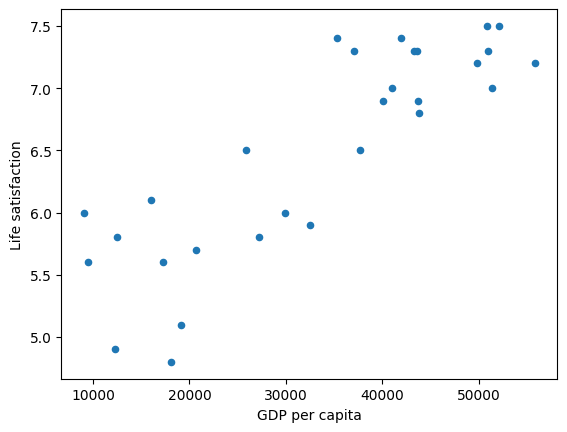

Prediction for Cyprus (Linear Regression): [[5.96242338]]


In [2]:
# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)

# Make a prediction for Cyprus
X_new = [[22587]]  # Cyprus's GDP per capita
print("Prediction for Cyprus (Linear Regression):", model.predict(X_new)) # outputs [[ 5.96242338]]

### Replacing the Linear Model with k-Nearest Neighbors

If we wanted to use an instance-based learning algorithm, we could replace the `LinearRegression` model with `KNeighborsRegressor`. A k-Nearest Neighbors regression model works by finding the $k$ closest countries (e.g., $k=3$) and averaging their life satisfaction.

In [3]:
import sklearn.neighbors

# Select a 3-Nearest Neighbors regression model
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

# Train the model
model.fit(X, y)

# Make a prediction for Cyprus
print("Prediction for Cyprus (k-NN):", model.predict(X_new)) # outputs [[ 5.76666667]]

Prediction for Cyprus (k-NN): [[5.76666667]]


## 4. Main Challenges of Machine Learning

In short, since your main task is to select a learning algorithm and train it on some data, the two things that can go wrong are "bad algorithm" and "bad data."

### Insufficient Quantity of Training Data
For a toddler to learn what an apple is, all it takes is for you to point to an apple and say "apple" (possibly repeating this procedure a few times). Now the child is able to recognize apples in all sorts of shapes and colors. Machine Learning is not quite there yet; it takes a lot of data for most Machine Learning algorithms to work properly. Even for very simple problems you typically need thousands of examples, and for complex problems such as image or speech recognition you may need millions of examples.

### Nonrepresentative Training Data
In order to generalize well, it is crucial that your training data be representative of the new cases you want to generalize to. This is true whether you use instance-based learning or model-based learning.

For example, the set of countries we used earlier for training the linear model was not perfectly representative; a few countries were missing. If we train on a nonrepresentative subset, the model might make inaccurate predictions for the missing cases. This is called **sampling bias**.

### Poor-Quality Data
Obviously, if your training data is full of errors, outliers, and noise (e.g., due to poor-quality measurements), it will make it harder for the system to detect the underlying patterns, so your system is less likely to perform well. It is often well worth the effort to spend time cleaning up your training data.

### Irrelevant Features
As the saying goes: garbage in, garbage out. Your system will only be capable of learning if the training data contains enough relevant features and not too many irrelevant ones. A critical part of the success of a Machine Learning project is coming up with a good set of features to train on. This process, called **feature engineering**, involves:
* **Feature selection:** selecting the most useful features to train on among existing features.
* **Feature extraction:** combining existing features to produce a more useful one (as we saw earlier, dimensionality reduction algorithms can help).
* **Creating new features:** by gathering new data.

### Overfitting the Training Data
Overfitting means that the model performs well on the training data, but it does not generalize well. It happens when the model is too complex relative to the amount and noisiness of the training data. The possible solutions are:
* To simplify the model by selecting one with fewer parameters (e.g., a linear model rather than a high-degree polynomial model), by reducing the number of attributes in the training data, or by constraining the model.
* To gather more training data.
* To reduce the noise in the training data (e.g., fix data errors and remove outliers).

### Underfitting the Training Data
As you might guess, underfitting is the opposite of overfitting: it occurs when your model is too simple to learn the underlying structure of the data. For example, a linear model of life satisfaction is prone to underfit; reality is just more complex than the model, so its predictions are bound to be inaccurate, even on the training examples.
The main options to fix this problem are:
* Selecting a more powerful model, with more parameters.
* Feeding better features to the learning algorithm (feature engineering).
* Reducing the constraints on the model (e.g., reducing the regularization hyperparameter).

## 5. Testing and Validating

The only way to know how well a model will generalize to new cases is to actually try it out on new cases. The better option is to split your data into two sets: the **training set** and the **test set**. As these names imply, you train your model using the training set, and you test it using the test set.

### Hyperparameter Tuning and Model Selection
So how do you choose the value of the regularization hyperparameter? One option is to train 100 different models using 100 different values for this hyperparameter. Suppose you find the best hyperparameter value that produces a model with the lowest generalization error, say just 5% error. You launch this model into production, but unfortunately it does not perform as well as expected and produces 15% errors. What just happened?

The problem is that you measured the generalization error multiple times on the test set, and you adapted the model and hyperparameters to produce the best model *for that particular set*. This means that the model is unlikely to perform as well on new data.

A common solution to this problem is called **holdout validation**. You simply hold out part of the training set to evaluate several candidate models and select the best one. The new held-out set is called the **validation set** (or **development set**, or **dev set**). You train multiple models with various hyperparameters on the reduced training set (i.e., the full training set minus the validation set), and you select the model that performs best on the validation set. After this holdout validation process, you train the best model on the full training set (including the validation set), and this gives you the final model. Lastly, you evaluate this final model on the test set to get an estimate of the generalization error.

### Data Mismatch
In some cases, it is easy to get a large amount of data for training, but this data probably won’t be perfectly representative of the data that will be used in production. For example, suppose you want to create a mobile app to take pictures of flowers and automatically determine their species. You can easily download millions of pictures of flowers on the web, but they won’t look like the pictures taken using the mobile app on a mobile device. In this case, the most important rule is that the validation set and the test set must be as representative as possible of the data you expect to use in production.

If your model performs poorly on the validation set, you do not know if it is because your model is overfitting the training set, or whether it is just due to the data mismatch. One solution is to hold out some of the training pictures (from the web) in yet another set that Andrew Ng calls the **train-dev set**. After the model is trained (on the training set, not on the train-dev set), you can evaluate it on the train-dev set. If it performs well, then the model is not overfitting the training set. If it performs poorly on the validation set, the problem must be coming from the data mismatch.

### No Free Lunch Theorem
A model is a simplified version of the observations. The simplifications are meant to discard the superfluous details that are unlikely to generalize to new instances. However, to decide what data to discard and what data to keep, you must make assumptions. For example, a linear model makes the assumption that the data is fundamentally linear and that the distance between the instances and the straight line is just noise, which can safely be ignored.

In a famous 1996 paper, David Wolpert demonstrated that if you make absolutely no assumption about the data, then there is no reason to prefer one model over any other. This is called the No Free Lunch (NFL) theorem. For some datasets the best model is a linear model, while for other datasets it is a neural network. There is no model that is guaranteed to work better (hence the name of the theorem). The only way to know for sure which model is best is to evaluate them all. Since this is not possible, in practice you make some reasonable assumptions about the data and you evaluate only a few reasonable models.